## word2vec 개선

### Embedding 계층

In [4]:
from cgi import print_arguments

import numpy as np
from transformers.utils import WEIGHTS_INDEX_NAME

from Scratch2.common.util import analogy

W = np.arange(21).reshape(7, 3)
W


array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [6]:
print(W[2])
print(W[5])

[6 7 8]
[15 16 17]


In [7]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [9]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        #W[self.idx] = dout
        for i , word_id in enumerate(self.idx):
            dW[word_id] += dout[i]

        return None

In [10]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [12]:
embed = Embedding(W)
target_W = embed.forward(idx)
out = np.sum(target_W, axis=1)

In [17]:
np.random.choice(10)

2

In [27]:
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'.'

In [37]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss, Affine
import collections


class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh


class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

In [39]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
pows =  0.75
sample_size = 2

sampler = UnigramSampler(corpus, pows, sample_size)
target = np.array([1,3,0])
nagative_sample = sampler.get_negative_sample(target)
print(nagative_sample)

[[3 4]
 [2 0]
 [3 2]]


In [40]:
np.random.choice(words, size=5)

array(['.', '.', 'goodbye', 'hello', '.'], dtype='<U7')

In [41]:
np.random.choice(words, size=5, replace=False)

array(['I', '.', 'hello', 'say', 'goodbye'], dtype='<U7')

In [42]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'I'

In [43]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


### 개선판 word2vec 학습

In [45]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Embedding

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V,H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        self.in_layers = []
        for i in range(2*window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 1[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 2[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 2[s] | 손실 3.92
| 에폭 1 |  반복 121 / 9295 | 시간 2[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 3[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 3[s] | 손실 3.50
| 에폭 1 |  반복 181 / 9295 | 시간 4[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 4[s] | 손실 3.27
| 에폭 1 |  반복 221 / 9295 | 시간 5[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 5[s] | 손실 3.10
| 에폭 1 |  반복 261 / 9295 | 시간 6[s] | 손실 3.01
| 에폭 1 |  반복 281 / 9295 | 시간 6[s] | 손실 2.97
| 에폭 1 |  반복 301 / 9295 | 시간 7[s] | 손실 2.94
| 에폭 1 |  반복 321 / 9295 | 시간 7[s] | 손실 2.87
| 에폭 1 |  반복 341 / 9295 | 시간 8[s] | 손실 2.85
| 에폭 1 |  반복 361 / 9295 | 시간 8[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 9[s] | 손실 2.81
| 에폭 1 |  반복 401 / 9295 | 시간 9[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 10[s] | 손실 2.75
| 에폭 1 |  반복 441 / 9295 | 시간 10[s] | 

/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

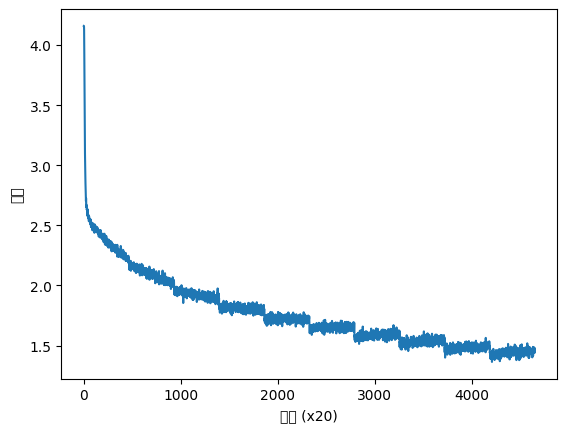

In [46]:
from common import config

import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

### CBOW 모델 평가

In [47]:
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.75634765625
 i: 0.7431640625
 your: 0.6318359375
 they: 0.59912109375
 weird: 0.56884765625

[query] year
 month: 0.83642578125
 week: 0.7890625
 spring: 0.775390625
 summer: 0.7734375
 decade: 0.6875

[query] car
 luxury: 0.58154296875
 truck: 0.57958984375
 window: 0.57666015625
 auto: 0.57470703125
 cars: 0.54833984375

[query] toyota
 seita: 0.646484375
 honda: 0.6357421875
 nissan: 0.62841796875
 chevrolet: 0.6181640625
 marathon: 0.60986328125
